In [86]:
from torchvision import datasets
from torchvision.transforms import ToTensor


In [87]:
traindata = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testData = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print("Train Data:\n ", traindata.data.shape) 
print (' ',traindata.targets)
print("-------------------------------------")
print( "Test Data:\n ", testData.data.shape)
print(' ',testData.targets)


100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Train Data:
  torch.Size([60000, 28, 28])
  tensor([5, 0, 4,  ..., 5, 6, 8])
-------------------------------------
Test Data:
  torch.Size([10000, 28, 28])
  tensor([7, 2, 1,  ..., 4, 5, 6])


In [88]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(traindata, batch_size=64, shuffle=True, num_workers=1),
    "test": DataLoader(testData, batch_size=64, shuffle=True, num_workers=1)
}

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x214c9eef650>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x214d61ec2d0>}

In [89]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)   
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      

In [90]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. *batch_idx / len(loaders["train"]):.0f}%)]\t: {loss.item():.6f}')
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(loaders["test"].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')


In [91]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	: 2.285877
Train Epoch: 1 [1280/60000 (2%)]	: 1.869983
Train Epoch: 1 [2560/60000 (4%)]	: 1.114871
Train Epoch: 1 [3840/60000 (6%)]	: 0.928979
Train Epoch: 1 [5120/60000 (9%)]	: 0.790591
Train Epoch: 1 [6400/60000 (11%)]	: 1.125751
Train Epoch: 1 [7680/60000 (13%)]	: 0.601316
Train Epoch: 1 [8960/60000 (15%)]	: 0.998472
Train Epoch: 1 [10240/60000 (17%)]	: 0.438084
Train Epoch: 1 [11520/60000 (19%)]	: 0.473875
Train Epoch: 1 [12800/60000 (21%)]	: 0.723163
Train Epoch: 1 [14080/60000 (23%)]	: 0.400096
Train Epoch: 1 [15360/60000 (26%)]	: 0.938090
Train Epoch: 1 [16640/60000 (28%)]	: 0.446986
Train Epoch: 1 [17920/60000 (30%)]	: 0.648649
Train Epoch: 1 [19200/60000 (32%)]	: 0.281794
Train Epoch: 1 [20480/60000 (34%)]	: 0.705787
Train Epoch: 1 [21760/60000 (36%)]	: 0.640270
Train Epoch: 1 [23040/60000 (38%)]	: 0.352523
Train Epoch: 1 [24320/60000 (41%)]	: 0.645596
Train Epoch: 1 [25600/60000 (43%)]	: 0.782242
Train Epoch: 1 [26880/60000 (45%)]	: 0.487938
Trai

In [92]:
device

device(type='cpu')

Prediction: 1


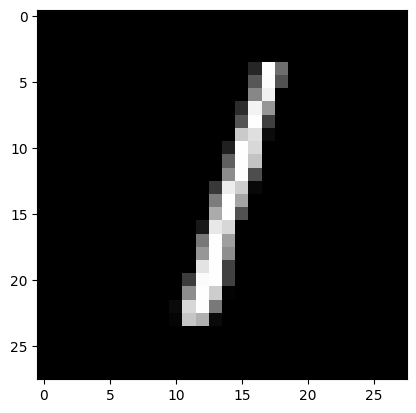

In [94]:
import matplotlib.pyplot as plt

model.eval()
data, target = testData[2]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap="gray")
plt.show()